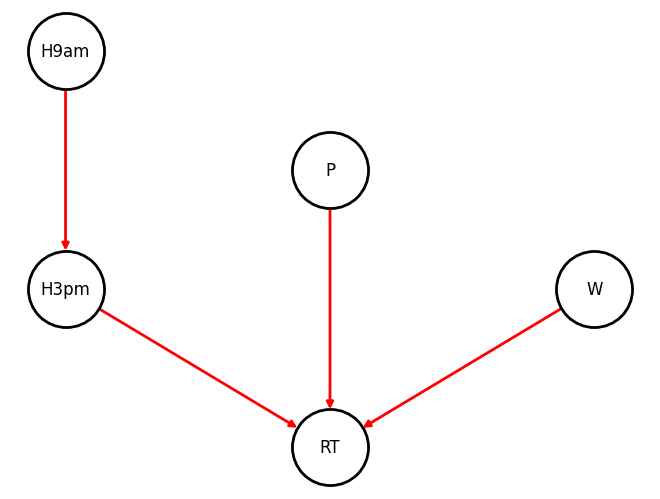


Node: 1|H3pm|<=60,>60
1=<=60|0.67286
1=>60|0.32714
------------------------------

Node: 0|H9am|<=60,>60
0=<=60|0.32005
0=>60|0.67995
------------------------------

Node: 2|W|<=40,40-50,>50
2=<=40|0.25849
2=40-50|0.55497
2=>50|0.18654
------------------------------

Node: 3|P|low,medium,high
3=low|0.36977
3=medium|0.03525
3=high|0.59498
------------------------------

Node: 4|RT|No,Yes
4=No|0.59660
4=Yes|0.40340
------------------------------

Updated marginals (after evidence):

Node: 1|H3pm|<=60,>60
1=<=60|0.00000
1=>60|1.00000
------------------------------

Node: 0|H9am|<=60,>60
0=<=60|0.06673
0=>60|0.93327
------------------------------

Node: 2|W|<=40,40-50,>50
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
------------------------------

Node: 3|P|low,medium,high
3=low|0.00000
3=medium|0.00000
3=high|1.00000
------------------------------

Node: 4|RT|No,Yes
4=No|0.31544
4=Yes|0.68456
------------------------------


In [32]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

def probs(data, child, parent1=None, parent2=None, parent3=None):
    if parent1 is None:
        # No parents
        prob = pd.crosstab(data[child], columns='count', normalize='columns').sort_index().to_numpy().flatten().tolist()
    elif parent2 is None:
        # One parent
        prob = pd.crosstab(data[parent1], data[child], normalize='index').sort_index().to_numpy().flatten().tolist()
    elif parent3 is None:
        # Two parents
        prob = pd.crosstab([data[parent1], data[parent2]], data[child], normalize='index').sort_index().to_numpy().flatten().tolist()
    else:
        # Three parents
        prob = pd.crosstab([data[parent1], data[parent2], data[parent3]], data[child], normalize='index').sort_index().to_numpy().flatten().tolist()
    return prob

def print_marginals():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print(f"\nNode: {node}")
        print(potential)
        print('-' * 30)

def add_evidence(node_name, category, value=1.0):
    ev = EvidenceBuilder() \
        .with_node(join_tree.get_bbn_node_by_name(node_name)) \
        .with_evidence(category, value) \
        .build()
    join_tree.set_observation(ev)

data = pd.read_csv('weatherAUS.csv', delimiter=';')
features = ['WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'RainTomorrow']
df = data[features].dropna().copy()

df['WindGustSpeedCat'] = df['WindGustSpeed'].apply(lambda x: '<=40' if x <= 40 else
                                                             '40-50' if x <= 50 else '>50')
df['Humidity9amCat'] = df['Humidity9am'].apply(lambda x: '>60' if x > 60 else '<=60')
df['Humidity3pmCat'] = df['Humidity3pm'].apply(lambda x: '>60' if x > 60 else '<=60')
df['Pressure9amCat'] = df['Pressure9am'].apply(lambda x: 'low' if x < 1005 else
                                                         'medium' if x < 1020 else 'high')

H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
P9am = BbnNode(Variable(3, 'P', ['low', 'medium', 'high']), probs(df, child='Pressure9amCat'))
RT = BbnNode(Variable(4, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Pressure9amCat', parent2='WindGustSpeedCat', parent3='Humidity3pmCat'))

bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(P9am) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(P9am, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)

pos = {
    0: (-2, 1.5),
    1: (-2, 0.0),
    2: (2, 0.0),
    3: (0, 0.75),
    4: (0, -1.0),
}
options = {
    "font_size": 12,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 2,
    "width": 2,
}
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)
plt.axis("off")
plt.show()

print_marginals()

add_evidence('H3pm', '>60')
add_evidence('W', '>50')
add_evidence('P', 'high')

print("\nUpdated marginals (after evidence):")
print_marginals()